In [1]:
from datasets import load_dataset, DatasetDict, load_from_disk, concatenate_datasets
import os

class CQADatasetLoader:
    def __init__(self, sample=1) -> None:
        # dataset specific
        self.dataset_name = 'cqa'
        self.source_dataset_name = 'cos_e'
        self.dataset_version = 'v1.11'
        self.has_valid = False
        self.path = "../datasets/cqa/"
        self.splits = [file.replace(".json", "") for file in os.listdir(self.path)]
        
        # settings for generation processes
        self.sample = sample
        
        # helper and assertion variables
        self.ready_for_rationalizing = False
        self.ready_for_critique = False
        self.ready_for_revision = False
        self.ready_for_cfrationalizing = False # cf = counterfactual
        self._seed = 42

    def _load_from_json(self):
            data_files = {f'{split}': f'../datasets/cqa/{split}.json' for split in self.splits}
            return load_dataset('json', data_files=data_files)

In [2]:
dataset = CQADatasetLoader()._load_from_json()
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'choices', 'answer', 'abstractive_explanation', 'extractive_explanation'],
        num_rows: 9741
    })
    validation: Dataset({
        features: ['id', 'question', 'choices', 'answer', 'abstractive_explanation', 'extractive_explanation'],
        num_rows: 1221
    })
})

In [6]:
def get_distribution(dataset):
    choices = {"A": [], "B": [], "C": [], "D": [], "E": []}
    num_to_let = {1: "A", 2: "B", 3: "C", 4: "D", 5: "E"}

    for item in dataset['choices']:
        for i, choice in enumerate(item):
            letter = num_to_let[i+1]
            choices[letter].append(choice)
            
    return choices

train_dist = get_distribution(dataset['train'])
test_dist = get_distribution(dataset['validation'])

In [7]:
for key in train_dist.keys():
    print("Example: ", train_dist[key][0], end=" - ")
    print("Length: ", len(train_dist[key]))

Example:  park - Length:  9741
Example:  coloring book - Length:  9741
Example:  garden center - Length:  9741
Example:  math problem - Length:  9741
Example:  gravity - Length:  9741


In [9]:
import numpy as np

def get_true_answer_distribution(dataset, distribution):
    answers = dataset["answer"]
    true_answers = {}

    for key in distribution.keys():
        true_answers[key] = np.sum(np.array(distribution[key]) == np.array(answers))
        
    return true_answers

train_answer_dist = get_true_answer_distribution(dataset['train'], train_dist)
test_answer_dist = get_true_answer_distribution(dataset['validation'], test_dist)

In [25]:
pd.DataFrame(train_answer_dist, index=["train"])

,A,B,C,D,E
train,1914,1982,1956,1991,1940


In [29]:
import pandas as pd 

df = pd.concat(
    [pd.DataFrame(data, index=[index]) for index, data in zip(["train", "test"], [train_answer_dist, test_answer_dist])],
).T

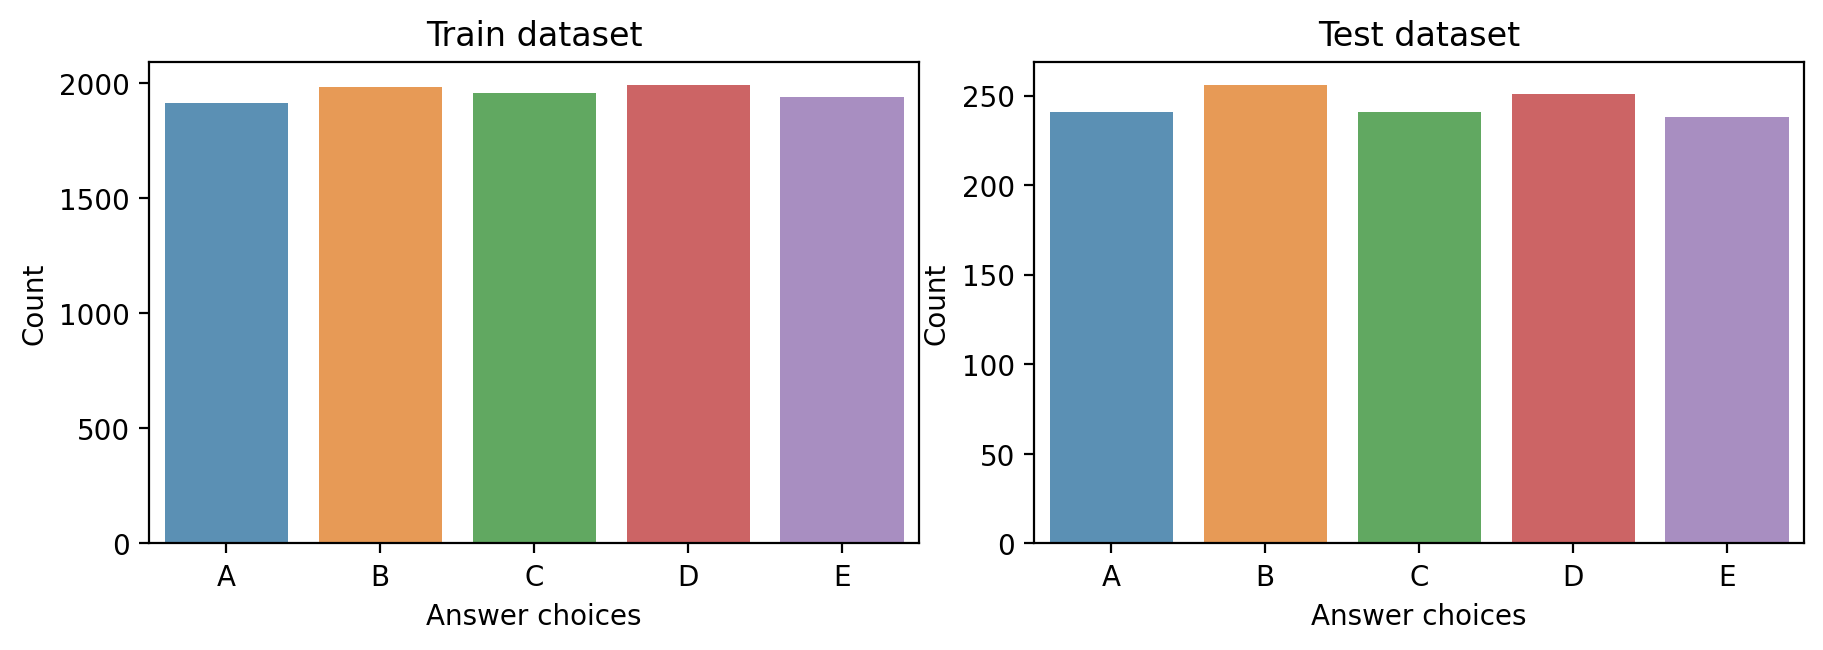

In [53]:
import seaborn as sns 
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'  # You can also use 'svg' or 'png'
%matplotlib inline

titles = ("Train dataset", "Test dataset")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,3), sharex=True)
fig.tight_layout()

for i, split in enumerate(["train", "test"]):
    sns.barplot(
        data=df[[split]].T,
        ax=axs[i],
        alpha=0.8
        )
    
    axs[i].set_xlabel('Answer choices')
    axs[i].set_ylabel('Count')
    axs[i].set_title(titles[i]);

In [54]:
fig.savefig("../figures/answer_choice_dist.png", dpi=300)